# Телеком — Поиск клиентов с неоптимальными тарифами.

Описание проекта: 

Заказчик - отдел по работе с клиентами провайдера виртуальный телефонии. Его клиенты — колл-центры, которые: распределяют входящие вызовы на операторов, совершают исходящие вызовы силами операторов. Также операторы могут делать внутренние вызовы — вызовы друг между другом внутри сети виртуальной телефонии. Датасеты описывают использование услуг «Нупозвони». Необходимо найти клиентов, которые:  а) переплачивают на текущих тарифах;  б) сэкономят, если перейдут на более дорогой тариф.

Правила формирования тарифов:

Ежемесячная плата за тариф:
* Тариф А — 4000, ₽
* Тариф B — 2000, ₽
* Тариф С — 1000, ₽

Дополнительная ежемесячная плата за
каждого оператора:
* Тариф А — 50 ₽,
* Тариф B — 150 ₽,
* Тариф С — 300 ₽

Входящие и внутренние звонки — бесплатны на всех тарифах,

Исходящие звонки внутри сети, включённые в тариф:
* Тариф А — 2000 минут,
* Тариф B — 500 минут,
* Тариф С — нет

Цена сверх лимита:
* A — 0.1 /мин., ₽
* B — 0.15 /мин., ₽
* C — 0.3 ₽/мин.

Исходящие звонки, кроме внутренних:
* A — 0.3 ₽/мин.,
* B — 0.5 ₽/мин.,
* C — 0.7 ₽/мин.

Задачи проекта:
* Провести исследовательский анализ данных.
* Получить расходы клиентов на каждом тарифе.
* Выделить клиентов, для которых оптимальный тариф не совпадает с текщим.
* Показать изменения в выручке для заказчика (общей, в месяц, на клиента) при смене тарифов.
* Проанализировать полученные результаты
* Предложить и проверить 2 статистические гипотезы.

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats as st

Импортируем библиотеки.

In [2]:
clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')

In [3]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [4]:
clients['date_start'] = pd.to_datetime(clients['date_start'])

In [5]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [6]:
clients.duplicated().sum()

0

In [7]:
clients['user_id'].duplicated().sum()

0

Загрузили датасет clients. Поменяли формат даты в дате начала использования тарифа. Пропущенных значений в данных нет, полные дубликаты также отсутствуют.

In [8]:
dataset = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

In [9]:
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [10]:
dataset['date'].min()

'2019-08-02 00:00:00+03:00'

In [11]:
dataset['date'].max()

'2019-11-28 00:00:00+03:00'

In [12]:
dataset['date'] = pd.to_datetime(dataset['date']).dt.tz_localize(None)

In [13]:
dataset['operator_id'] = dataset['operator_id'].astype('Int64')

In [14]:
dataset.head(15)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,<NA>,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
5,166377,2019-08-05,out,False,880020,False,2,3,29
6,166377,2019-08-05,out,False,880020,True,8,0,50
7,166377,2019-08-05,in,False,<NA>,True,6,0,35
8,166377,2019-08-05,out,False,880020,True,8,0,50
9,166377,2019-08-06,in,False,<NA>,True,4,0,62


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  Int64         
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
dtypes: Int64(1), bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 3.4+ MB


In [16]:
dataset.duplicated().sum()

4900

In [17]:
dataset.duplicated(subset=['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call']).sum()

4900

В датасете 4900 полных дубликатов. Это скорее всего техническая ошибка, так как других повторов по всем столбцам кроме продолжительности звонков не обнарружено. поэтому удалим их.

In [18]:
dataset.drop_duplicates(inplace=True)

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41546 non-null  Int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: Int64(1), bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 3.5+ MB


In [20]:
dataset = dataset.dropna(subset=['internal'])

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41491 non-null  Int64         
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: Int64(1), bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 3.5+ MB


Проверим, что в признаке внутренний/внешний звонок находятся только подходящие значения.

In [22]:
dataset['direction'].value_counts()

out    28997
in     19895
Name: direction, dtype: int64

In [23]:
19895 / 28997

0.686105459185433

Загрузили датасет dataset. Поменяли формат даты в столбце date, а также тип данных у столбца operator_id на целочисленный тип. В данных 4900 полных дубликата - удалим их, чтобы они не искажали анализ. Пропущенные значения присутсвуют в столбце internal  - их небольшое количество, около 0,2 процента. Предлагаю их удалить, чтобы они не мешали расчету платы за тариф. Также пропуски присутствуют в стобце operator_id - их около 15 процентов, пока оставим их без изменений, решение примем в процессе исследования.

Провели предобработку данных, сменили формат даты, формат operator_id, удалили дубликаты. Пропуски в двух столбцах. По стоблцу internal данные с пропусками удалили, по столбцу operator_id оставили для дальнейшего анализа.

## Исследовательский анализ данных

### Определение активных пользователей

In [24]:
dataset['date'].dt.date.min()

datetime.date(2019, 8, 2)

In [25]:
dataset['date'].dt.date.max()

datetime.date(2019, 11, 28)

У нас есть данные со 2 августа до 28 ноября. Необходимо опеределить активных пользователей, которых мы будем использовать в анализе.

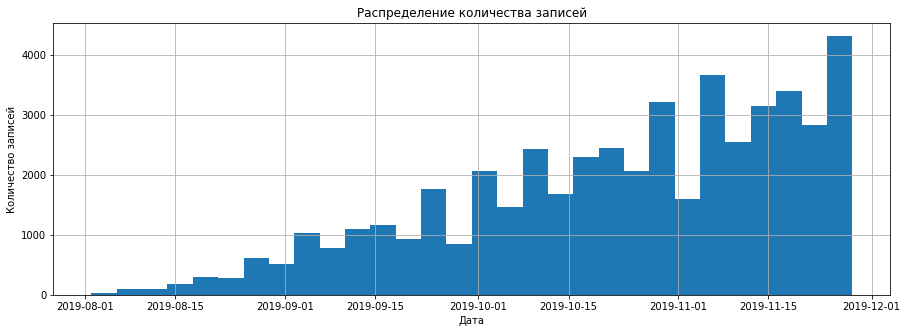

In [26]:
dataset['date'].hist(bins = 30, figsize=(15, 5))
plt.title('Распределение количества записей')
plt.ylabel('Количество записей')
plt.xlabel('Дата')
plt.show()

На гистограмме количества записей по датам виден рост с конца августа.

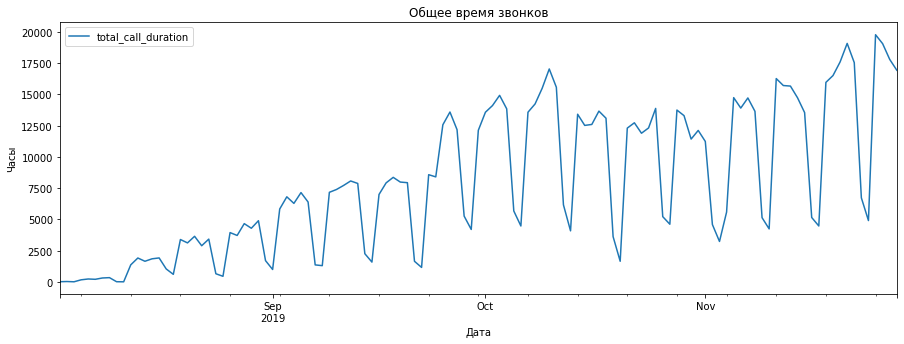

In [27]:
dataset.groupby(['date']).agg({'total_call_duration': 'sum'}).assign(total_call_duration = lambda x: \
                                                                     x['total_call_duration'] / 60).plot(figsize=(15, 5))
plt.title('Общее время звонков')
plt.ylabel('Часы')
plt.xlabel('Дата')
plt.show()

In [28]:
dataset.groupby(['date']).agg({'total_call_duration': 'sum'}).assign(total_call_duration = lambda x: \
                                                                     x['total_call_duration'] / 60).mean()

total_call_duration    7936.229272
dtype: float64

Общее время звонков постоянно растет, самый активный рост происходит в концке сентября и начале октября. Среднее время продолжительности звонков в день - 132 часа. Видим цикличные колебания графика - они происходят в течени недели.

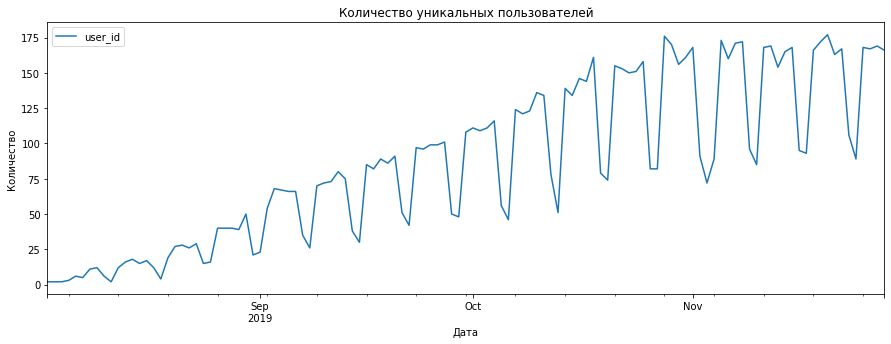

In [29]:
dataset.groupby(['date']).agg({'user_id': 'nunique'}).plot(figsize=(15, 5))
plt.title('Количество уникальных пользователей')
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.show()

In [30]:
dataset.groupby(['date']).agg({'user_id': 'nunique'}).mean()

user_id    87.294118
dtype: float64

Количество уникальных пользователей растет в течении всего времени. Среднее количетсво пользователей в день - 87. Видим цикличные колебания графика - они происходят в течени недели.

In [31]:
dataset_act = dataset.loc[dataset['date']>='2019, 9, 1'].copy()

In [32]:
dataset_act.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
118,166377,2019-09-02,in,False,880028,False,2,66,75
119,166377,2019-09-02,in,False,880026,False,1,31,34
120,166377,2019-09-02,out,False,880026,False,16,1853,1983
121,166377,2019-09-02,out,False,880026,True,6,0,168
122,166377,2019-09-02,out,False,880028,False,20,2529,2687


In [33]:
dataset_act.agg({'user_id': 'nunique'})

user_id    303
dtype: int64

In [34]:
dataset_act.agg({'user_id': 'nunique'}) / dataset.agg({'user_id': 'nunique'}) * 100

user_id    98.697068
dtype: float64

Так как основной рост количества пользователей и суммарного времени звонков начинается в сентябре, для работы оставим пользователей, которые совершали звонки в период с сентября по ноябрб. Их 303, это 98.7 процентов от изначального количества.

Найжем общую продолжительность звонков в часах.

In [35]:
call_duration_in = pd.DataFrame(
    dataset_act.loc[dataset_act['direction'] == 'in']
        .groupby(['user_id', 'operator_id', 'date'], as_index=False)
        .agg({'call_duration': 'sum'})
        .assign(duration_in = lambda x: x['call_duration'] / 60))
call_duration_out = pd.DataFrame(
    dataset_act.loc[dataset_act['direction'] == 'out']
        .groupby(['user_id', 'operator_id', 'date'], as_index=False)
        .agg({'total_call_duration': 'sum'})
        .assign(duration_out = lambda x: x['total_call_duration'] / 60))
call_duration = call_duration_in.merge(call_duration_out, on=['user_id', 'operator_id', 'date'])
call_duration['sum_duration'] = call_duration['duration_in'] + call_duration['duration_out']
call_duration.sort_values(by='sum_duration', ascending=False)

,user_id,operator_id,date,call_duration,duration_in,total_call_duration,duration_out,sum_duration
864,166582,885876,2019-09-25,611,10.183333,189236,3153.933333,3164.116667
865,166582,885876,2019-09-26,4932,82.200000,166851,2780.850000,2863.050000
851,166582,885876,2019-09-09,1428,23.800000,159032,2650.533333,2674.333333
858,166582,885876,2019-09-18,172,2.866667,158965,2649.416667,2652.283333
870,166582,885876,2019-10-02,1933,32.216667,153328,2555.466667,2587.683333
...,...,...,...,...,...,...,...,...
3708,167180,905932,2019-09-19,2,0.033333,4,0.066667,0.100000
5780,168062,947610,2019-10-28,5,0.083333,0,0.000000,0.083333
5002,167654,918986,2019-10-01,4,0.066667,0,0.000000,0.066667
3579,167176,907504,2019-09-09,3,0.050000,0,0.000000,0.050000


Рассмотрели общую продолжительность звонков в день (для входящих время ожидания не входит, для исходящих - входит). Видно, что эта продолжительность для некоторых операторов в некоторые дни превышает время возможного рабочего дня. Это происходит из-за того, что имеюстя звонки аномально длинные. Необходимо от них избавиться.

In [36]:
dataset_act['total_call_duration_h'] = dataset_act['total_call_duration'] / 60

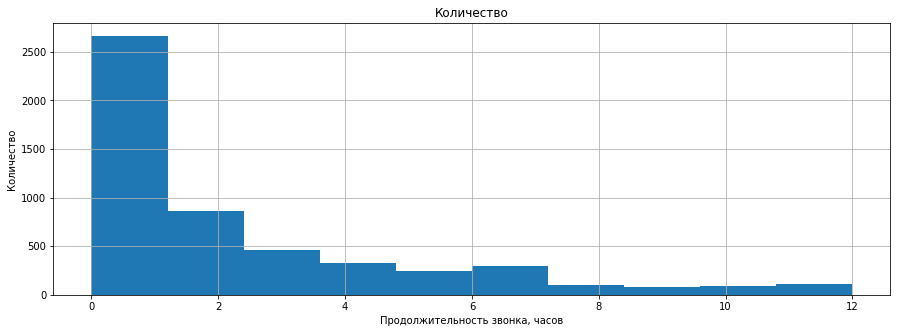

In [37]:
dataset_act.groupby(['total_call_duration_h']).agg({'user_id': 'count'}).hist(bins=10, figsize=(15, 5), range=[0, 12])
plt.title('Количество')
plt.ylabel('Количество')
plt.xlabel('Продолжительность звонка, часов')
plt.show()

In [38]:
dataset_act = dataset_act.loc[dataset_act['total_call_duration_h'] <= 12]

Рассмотрели продолжительность каждого звонка. Примем, что звонок за одну смену не может продолжаться дольше 12 часов. Исключим такие длинные звонки из анализа.

In [39]:
dataset_act['user_id'].nunique()

303

In [40]:
dataset_act['operator_id'].nunique()

1054

In [41]:
dataset_act.agg({'user_id': 'nunique'}) / dataset.agg({'user_id': 'nunique'}) * 100

user_id    98.697068
dtype: float64

Выделили активных пользователей - взяли период с откбря по ноябрь и исключили аномально длинные звонки. Всего мы потеряли около 1.3 процентов пользователей из анализа. У нас осталось 303 пользователей и 1054 оператора.

### Расчет выручки

In [42]:
dataset_act['month'] = dataset_act['date'].dt.month

Добавили столбец с месяцем статистики.

In [43]:
dataset_act

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,total_call_duration_h,month
118,166377,2019-09-02,in,False,880028,False,2,66,75,1.250000,9
119,166377,2019-09-02,in,False,880026,False,1,31,34,0.566667,9
121,166377,2019-09-02,out,False,880026,True,6,0,168,2.800000,9
124,166377,2019-09-02,out,True,880020,True,2,0,0,0.000000,9
125,166377,2019-09-02,out,False,880020,True,2,0,3,0.050000,9
...,...,...,...,...,...,...,...,...,...,...,...
53895,168606,2019-11-09,out,False,957922,False,4,551,593,9.883333,11
53896,168606,2019-11-10,out,True,957922,False,1,0,25,0.416667,11
53897,168606,2019-11-10,out,True,957922,True,1,0,38,0.633333,11
53898,168606,2019-11-11,out,True,957922,False,2,479,501,8.350000,11


У нас остались пропуски в 'operator_id'. Посмотрим, на какие звонки они приходятся и как с ними поступить.

In [44]:
dataset['no_operator'] = dataset_act['operator_id'].isnull()

In [45]:
no_operator = dataset.loc[dataset['no_operator'] == True]
no_operator

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,no_operator
127,166377,2019-09-03,in,False,<NA>,True,1,0,20,True
134,166377,2019-09-04,in,False,<NA>,True,1,0,19,True
146,166377,2019-09-05,in,False,<NA>,True,2,0,23,True
166,166377,2019-09-09,in,False,<NA>,True,1,0,29,True
169,166377,2019-09-10,in,False,<NA>,True,1,0,26,True
...,...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27,in,False,<NA>,True,2,0,39,True
53880,168601,2019-11-28,in,False,<NA>,True,1,0,19,True
53889,168603,2019-11-28,in,False,<NA>,True,1,0,30,True
53893,168606,2019-11-08,in,False,<NA>,True,6,0,121,True


In [46]:
no_operator.groupby('user_id', as_index=False)['no_operator'].sum().sort_values(by='no_operator', ascending=False)


,user_id,no_operator
47,166782,100
76,166983,90
27,166658,84
18,166541,78
64,166916,77
...,...,...
229,168010,True
230,168013,True
240,168048,True
261,168202,True


In [47]:
no_operator.groupby('direction', as_index=False)['no_operator'].sum().sort_values(by='no_operator', ascending=False)


,direction,no_operator
0,in,6424
1,out,151


Мы видим, что почти все звонки с пропущенным оператором это входящие звонки, плата за которые входит в абоненскую плату. На исходящие звонки приходится небольшое количество пропусков. Предлагаю никак от них не избавляться.

In [48]:
out_False = (
    dataset_act.loc[(dataset_act['direction'] == 'out') & (dataset_act['internal'] == False)]
        .groupby(['user_id', 'month'], as_index=False,)
        .agg({'total_call_duration': 'sum'})
)
out_False

,user_id,month,total_call_duration
0,166377,9,16233
1,166377,10,13779
2,166377,11,12332
3,166405,9,10800
4,166405,10,26089
...,...,...,...
453,168481,11,425
454,168500,11,12
455,168601,11,4907
456,168603,11,1187


Посчитали суммарное время на исходящие внешние звонки.

In [49]:
out_True = (
    dataset_act
        .loc[(dataset_act['direction'] == 'out') & (dataset_act['internal'] == True)]
        .groupby(['user_id', 'month'], as_index=False)
        .agg({'total_call_duration': 'sum'})
)
out_True

,user_id,month,total_call_duration
0,166377,9,9
1,166377,10,5
2,166377,11,127
3,166405,10,778
4,166405,11,115
...,...,...,...
245,168416,10,0
246,168416,11,0
247,168500,11,30
248,168601,11,0


Посчитали суммарное время на исходящие внутренние звонки.

In [50]:
out = out_False.merge(out_True, how='left', on = ['user_id', 'month'])
out

,user_id,month,total_call_duration_x,total_call_duration_y
0,166377,9,16233,9.0
1,166377,10,13779,5.0
2,166377,11,12332,127.0
3,166405,9,10800,NaN
4,166405,10,26089,778.0
...,...,...,...,...
453,168481,11,425,NaN
454,168500,11,12,30.0
455,168601,11,4907,0.0
456,168603,11,1187,NaN


In [51]:
out['total_call_out_False'] = out['total_call_duration_x'].fillna(0)
out['total_call_out_True'] = out['total_call_duration_y'].fillna(0)
out

,user_id,month,total_call_duration_x,total_call_duration_y,total_call_out_False,total_call_out_True
0,166377,9,16233,9.0,16233,9.0
1,166377,10,13779,5.0,13779,5.0
2,166377,11,12332,127.0,12332,127.0
3,166405,9,10800,NaN,10800,0.0
4,166405,10,26089,778.0,26089,778.0
...,...,...,...,...,...,...
453,168481,11,425,NaN,425,0.0
454,168500,11,12,30.0,12,30.0
455,168601,11,4907,0.0,4907,0.0
456,168603,11,1187,NaN,1187,0.0


In [52]:
out = out.merge(clients, on='user_id')
out = out.drop(columns = ['total_call_duration_y', 'total_call_duration_x', 'date_start'], axis = 1)

In [53]:
out = out.merge(dataset_act.groupby(['user_id'])['operator_id'].nunique(), on=['user_id'])

In [54]:
out

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id
0,166377,9,16233,9.0,B,5
1,166377,10,13779,5.0,B,5
2,166377,11,12332,127.0,B,5
3,166405,9,10800,0.0,B,10
4,166405,10,26089,778.0,B,10
...,...,...,...,...,...,...
453,168481,11,425,0.0,B,3
454,168500,11,12,30.0,B,1
455,168601,11,4907,0.0,C,2
456,168603,11,1187,0.0,B,1


Добавили столбец с тарифным планом и с количетсвом операторов на пользователя.

In [55]:
def tariff_calc(
    monthly_cost,
    operator_count_monthly_cost,
    prepayed_internal_minutes,
    interanal_minute_cost,
    external_minute_cost,
):
    def _calc(external_minutes, internal_minutes, operator_count):
        return (
            external_minutes * external_minute_cost
            + np.minimum(internal_minutes - prepayed_internal_minutes, 0) * interanal_minute_cost
            + monthly_cost
            + operator_count * operator_count_monthly_cost
        )
    return _calc

tariff_A_calc = tariff_calc(4000, 50, 2000, 0.1, 0.3)
tariff_B_calc = tariff_calc(2000, 150, 500, 0.15, 0.5)
tariff_C_calc = tariff_calc(1000, 300, 0, 0.3, 0.7)

In [56]:
out.loc[out['tariff_plan'] == 'A', 'pay'] = out.apply(
    lambda row: tariff_A_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
out.loc[out['tariff_plan'] == 'B', 'pay'] = out.apply(
    lambda row: tariff_B_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
out.loc[out['tariff_plan'] == 'C', 'pay'] = out.apply(
    lambda row: tariff_C_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
out['pay'] = out['pay'].fillna(0)
out

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay
0,166377,9,16233,9.0,B,5,10792.85
1,166377,10,13779,5.0,B,5,9565.25
2,166377,11,12332,127.0,B,5,8860.05
3,166405,9,10800,0.0,B,10,8825.00
4,166405,10,26089,778.0,B,10,16544.50
...,...,...,...,...,...,...,...
453,168481,11,425,0.0,B,3,2587.50
454,168500,11,12,30.0,B,1,2085.50
455,168601,11,4907,0.0,C,2,5034.90
456,168603,11,1187,0.0,B,1,2668.50


Подсчитали прибыль с каждого пользователя исходя из тарифного плана.

### Поиск клиекнтов с невыгодными тарифами

Найдем медианные значения платы на каждом тарифе:

In [57]:
out.loc[out['tariff_plan'] == 'A']['pay'].median()

5483.6

In [58]:
out.loc[out['tariff_plan'] == 'B']['pay'].median()

4117.75

In [59]:
out.loc[out['tariff_plan'] == 'C']['pay'].median()

3497.1499999999996

Медианная плата на тарифе А - 5483.6, на тарифе B - 4117.5, на тарифе С - 3497.1. Медианная плата на тарифе А близка к абоненской плате, так как в тариф включено достаточное количетсво минут, а стоимость остальных услуг низкая. По тарифу В и С медианная плата сильно превышает абоненскую плату по тарифу. Теперь найдем тех пользователей, которые переплачивают по сравнению с медианным значением на тарифе.

In [60]:
out.loc[(out['tariff_plan'] == 'A') & (out['pay'] > out.loc[out['tariff_plan'] == 'A']['pay'].median())]['user_id'].nunique()

16

In [61]:
out.loc[(out['tariff_plan'] == 'B') & (out['pay'] > out.loc[out['tariff_plan'] == 'B']['pay'].median())]['user_id'].nunique()

46

In [62]:
out.loc[(out['tariff_plan'] == 'C') & (out['pay'] > out.loc[out['tariff_plan'] == 'C']['pay'].median())]['user_id'].nunique()

54

Нашли, что 16 пользователей переплачивают на тарифе А, 46 на тарифе В и 54 на тарифе С хотя бы в одном месяце из двух.

In [63]:
a = pd.DataFrame(
    out.loc[(out['tariff_plan'] == 'A') & (out['pay'] > out.loc[out['tariff_plan'] == 'A']['pay'].median())]
        .groupby('user_id', as_index=False).count())
#a = a.loc[a['month'] > 1]
b = pd.DataFrame(
    out.loc[(out['tariff_plan'] == 'B') & (out['pay'] > out.loc[out['tariff_plan'] == 'B']['pay'].median())]
        .groupby('user_id', as_index=False).count())
#b = b.loc[b['month'] > 1]
c = pd.DataFrame(
    out.loc[(out['tariff_plan'] == 'C') & (out['pay'] > out.loc[out['tariff_plan'] == 'C']['pay'].median())]
    .groupby('user_id', as_index=False).count())
#c = c.loc[c['month'] > 1]
new_tariff_users = pd.concat([a,b,c])
new_tariff_users

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay
0,166407,2,2,2,2,2,2
1,166725,3,3,3,3,3,3
2,166843,1,1,1,1,1,1
3,166916,2,2,2,2,2,2
4,167497,2,2,2,2,2,2
...,...,...,...,...,...,...,...
49,168271,1,1,1,1,1,1
50,168336,2,2,2,2,2,2
51,168412,1,1,1,1,1,1
52,168416,1,1,1,1,1,1


In [64]:
new_tariff_users.groupby(['month']).nunique()

,user_id,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay
month,,,,,,
1,38,1,1,1,1,1
2,44,1,1,1,1,1
3,34,1,1,1,1,1


38 пользователей переплачивают одном месяце, 44 в двух, 34 в трех.

In [65]:
over = out.query('user_id in @new_tariff_users.user_id').copy()
over

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay
0,166377,9,16233,9.0,B,5,10792.85
1,166377,10,13779,5.0,B,5,9565.25
2,166377,11,12332,127.0,B,5,8860.05
3,166405,9,10800,0.0,B,10,8825.00
4,166405,10,26089,778.0,B,10,16544.50
...,...,...,...,...,...,...,...
446,168361,11,77283,37.0,A,27,28338.60
447,168412,11,12238,9.0,C,9,12266.60
448,168416,10,1573,0.0,C,1,2401.10
449,168416,11,7287,0.0,C,1,6400.90


In [66]:
over['A'] = over.apply(
    lambda row: tariff_A_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
over['B'] = over.apply(
    lambda row: tariff_B_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
over['C'] = over.apply(
    lambda row: tariff_C_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
over

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,A,B,C
0,166377,9,16233,9.0,B,5,10792.85,8920.8,10792.85,13863.1
1,166377,10,13779,5.0,B,5,9565.25,8184.2,9565.25,12145.3
2,166377,11,12332,127.0,B,5,8860.05,7762.3,8860.05,11132.4
3,166405,9,10800,0.0,B,10,8825.00,7540.0,8825.00,11560.0
4,166405,10,26089,778.0,B,10,16544.50,12204.5,16544.50,22262.3
...,...,...,...,...,...,...,...,...,...,...
446,168361,11,77283,37.0,A,27,28338.60,28338.6,44622.05,63198.1
447,168412,11,12238,9.0,C,9,12266.60,7922.3,9395.35,12266.6
448,168416,10,1573,0.0,C,1,2401.10,4321.9,2861.50,2401.1
449,168416,11,7287,0.0,C,1,6400.90,6036.1,5718.50,6400.9


Теперь найдем выгодный тариф для пользователей, для которых это возможно.

In [67]:
over['new_tariff_plan'] = over[['A', 'B', 'C']].idxmin(axis=1)

In [68]:
over['new_pay'] = over.apply(lambda row: row[row['new_tariff_plan']], axis='columns')

In [69]:
over['profit'] = over.apply(lambda row: row[row['tariff_plan']] - row[row['new_tariff_plan']], axis='columns')
over

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,A,B,C,new_tariff_plan,new_pay,profit
0,166377,9,16233,9.0,B,5,10792.85,8920.8,10792.85,13863.1,A,8920.8,1872.05
1,166377,10,13779,5.0,B,5,9565.25,8184.2,9565.25,12145.3,A,8184.2,1381.05
2,166377,11,12332,127.0,B,5,8860.05,7762.3,8860.05,11132.4,A,7762.3,1097.75
3,166405,9,10800,0.0,B,10,8825.00,7540.0,8825.00,11560.0,A,7540.0,1285.00
4,166405,10,26089,778.0,B,10,16544.50,12204.5,16544.50,22262.3,A,12204.5,4340.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,168361,11,77283,37.0,A,27,28338.60,28338.6,44622.05,63198.1,A,28338.6,0.00
447,168412,11,12238,9.0,C,9,12266.60,7922.3,9395.35,12266.6,A,7922.3,4344.30
448,168416,10,1573,0.0,C,1,2401.10,4321.9,2861.50,2401.1,C,2401.1,0.00
449,168416,11,7287,0.0,C,1,6400.90,6036.1,5718.50,6400.9,B,5718.5,682.40


In [70]:
change = over.loc[over['profit'] > 0]
change

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,A,B,C,new_tariff_plan,new_pay,profit
0,166377,9,16233,9.0,B,5,10792.85,8920.8,10792.85,13863.1,A,8920.8,1872.05
1,166377,10,13779,5.0,B,5,9565.25,8184.2,9565.25,12145.3,A,8184.2,1381.05
2,166377,11,12332,127.0,B,5,8860.05,7762.3,8860.05,11132.4,A,7762.3,1097.75
3,166405,9,10800,0.0,B,10,8825.00,7540.0,8825.00,11560.0,A,7540.0,1285.00
4,166405,10,26089,778.0,B,10,16544.50,12204.5,16544.50,22262.3,A,12204.5,4340.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,168336,10,1981,256.0,C,14,6586.70,5119.9,5053.90,6586.7,B,5053.9,1532.80
444,168336,11,15733,2206.0,C,14,16213.10,9419.9,11966.50,16213.1,A,9419.9,6793.20
447,168412,11,12238,9.0,C,9,12266.60,7922.3,9395.35,12266.6,A,7922.3,4344.30
449,168416,11,7287,0.0,C,1,6400.90,6036.1,5718.50,6400.9,B,5718.5,682.40


Вывели таблицу пользователей, для которых возможна выгодная смена тарифа. Теперь рассмотрим в каждом ли из трех месяцев пользователю выгодно менять тариф.

Теперь рассчитаем для пользователей с невогодными тарифами сколько они платили раньше, сколько они заплатили бы на выгодном тарифе и выгоду.

In [71]:
users = clients.loc[clients['user_id'].isin(dataset_act['user_id'].unique())].drop(['date_start'], axis=1)
users

,user_id,tariff_plan
0,166713,A
1,166901,A
4,168193,A
7,168252,A
16,168253,A
...,...,...
712,167530,B
713,167288,B
714,167009,B
715,167141,B


In [72]:
users = out.merge(over[['user_id', 'month', 'new_pay', 'new_tariff_plan', 'profit']], how='left', on = ['user_id', 'month'])
users['profit'] = users['profit'].fillna(0)
users['new_tariff_plan'] = users['new_tariff_plan'].fillna(users['tariff_plan'])
users['new_pay'] = users['new_pay'].fillna(users['pay'])
users

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,new_pay,new_tariff_plan,profit
0,166377,9,16233,9.0,B,5,10792.85,8920.8,A,1872.05
1,166377,10,13779,5.0,B,5,9565.25,8184.2,A,1381.05
2,166377,11,12332,127.0,B,5,8860.05,7762.3,A,1097.75
3,166405,9,10800,0.0,B,10,8825.00,7540.0,A,1285.00
4,166405,10,26089,778.0,B,10,16544.50,12204.5,A,4340.00
...,...,...,...,...,...,...,...,...,...,...
453,168481,11,425,0.0,B,3,2587.50,2587.5,B,0.00
454,168500,11,12,30.0,B,1,2085.50,2085.5,B,0.00
455,168601,11,4907,0.0,C,2,5034.90,4678.5,B,356.40
456,168603,11,1187,0.0,B,1,2668.50,2668.5,B,0.00


In [73]:
qwe = users.groupby('user_id', group_keys=False)['new_tariff_plan'].value_counts().reset_index(name='counts')
l = qwe.loc[qwe['counts'] > 1]
l

,user_id,new_tariff_plan,counts
0,166377,A,3
1,166405,A,3
2,166406,B,3
3,166407,A,2
5,166485,A,3
...,...,...,...
260,168228,B,2
261,168252,A,2
268,168307,B,2
271,168361,A,2


In [74]:
for id in l['user_id']:
    users.loc[users['user_id'] == id, 'new_tariff_plan'] = l.loc[l['user_id'] == id, 'new_tariff_plan'].iloc[0]

users.loc[users['new_tariff_plan'] == 'A', 'new_pay'] = users.apply(
        lambda row: tariff_A_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
users.loc[users['new_tariff_plan'] == 'B', 'new_pay'] = users.apply(
        lambda row: tariff_B_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
users.loc[users['new_tariff_plan'] == 'C', 'new_pay'] = users.apply(
        lambda row: tariff_C_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
users['profit'] = users['pay'] - users['new_pay']
users.loc[users['user_id'].isin(l['user_id'])]

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,new_pay,new_tariff_plan,profit
0,166377,9,16233,9.0,B,5,10792.85,8920.8,A,1872.05
1,166377,10,13779,5.0,B,5,9565.25,8184.2,A,1381.05
2,166377,11,12332,127.0,B,5,8860.05,7762.3,A,1097.75
3,166405,9,10800,0.0,B,10,8825.00,7540.0,A,1285.00
4,166405,10,26089,778.0,B,10,16544.50,12204.5,A,4340.00
...,...,...,...,...,...,...,...,...,...,...
442,168307,11,111,0.0,B,3,2430.50,2430.5,B,0.00
445,168361,10,24965,1.0,A,27,12639.60,12639.6,A,0.00
446,168361,11,77283,37.0,A,27,28338.60,28338.6,A,0.00
450,168466,10,0,0.0,C,2,1600.00,1600.0,C,0.00


In [75]:
users.loc[~users['user_id'].isin(l['user_id']), 'new_tariff_plan'] = users.loc[~users['user_id'].isin(l['user_id']), 'tariff_plan']
users.loc[~users['user_id'].isin(l['user_id']), 'new_pay'] = users.loc[~users['user_id'].isin(l['user_id']), 'pay']
users.loc[~users['user_id'].isin(l['user_id']), 'profit'] = 0
users.loc[~users['user_id'].isin(l['user_id'])]

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,new_pay,new_tariff_plan,profit
15,166487,11,3188,0.0,C,1,3531.6,3531.6,C,0.0
42,166609,9,73,0.0,A,3,3971.9,3971.9,A,0.0
77,166711,9,31,0.0,B,2,2240.5,2240.5,B,0.0
96,166803,9,23,0.0,C,2,1616.1,1616.1,C,0.0
125,166936,9,2981,0.0,C,1,3386.7,3386.7,C,0.0
...,...,...,...,...,...,...,...,...,...,...
453,168481,11,425,0.0,B,3,2587.5,2587.5,B,0.0
454,168500,11,12,30.0,B,1,2085.5,2085.5,B,0.0
455,168601,11,4907,0.0,C,2,5034.9,5034.9,C,0.0
456,168603,11,1187,0.0,B,1,2668.5,2668.5,B,0.0


In [76]:
users.loc[users['user_id'].isin(l['user_id'])]

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,new_pay,new_tariff_plan,profit
0,166377,9,16233,9.0,B,5,10792.85,8920.8,A,1872.05
1,166377,10,13779,5.0,B,5,9565.25,8184.2,A,1381.05
2,166377,11,12332,127.0,B,5,8860.05,7762.3,A,1097.75
3,166405,9,10800,0.0,B,10,8825.00,7540.0,A,1285.00
4,166405,10,26089,778.0,B,10,16544.50,12204.5,A,4340.00
...,...,...,...,...,...,...,...,...,...,...
442,168307,11,111,0.0,B,3,2430.50,2430.5,B,0.00
445,168361,10,24965,1.0,A,27,12639.60,12639.6,A,0.00
446,168361,11,77283,37.0,A,27,28338.60,28338.6,A,0.00
450,168466,10,0,0.0,C,2,1600.00,1600.0,C,0.00


In [77]:
users.head(15)

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,new_pay,new_tariff_plan,profit
0,166377,9,16233,9.0,B,5,10792.85,8920.8,A,1872.05
1,166377,10,13779,5.0,B,5,9565.25,8184.2,A,1381.05
2,166377,11,12332,127.0,B,5,8860.05,7762.3,A,1097.75
3,166405,9,10800,0.0,B,10,8825.00,7540.0,A,1285.00
4,166405,10,26089,778.0,B,10,16544.50,12204.5,A,4340.00
5,166405,11,23623,115.0,B,10,15253.75,11398.4,A,3855.35
6,166406,9,6690,28.0,B,2,5574.20,5574.2,B,0.00
7,166406,10,6632,814.0,B,2,5616.00,5616.0,B,0.00
8,166406,11,5673,0.0,B,2,5061.50,5061.5,B,0.00
9,166407,9,1512,5348.0,A,8,4853.60,4853.6,A,0.00


In [78]:
qwe = users.groupby('user_id', as_index=False)['new_tariff_plan'].nunique()
l = qwe.loc[qwe['new_tariff_plan'] > 1]
l

,user_id,new_tariff_plan


Убедились, что  у нас не осталось дубликатов в новом тарифе по каждому пользователю.

In [79]:
users.loc[users['tariff_plan'] != users['new_tariff_plan']].count()

user_id                 141
month                   141
total_call_out_False    141
total_call_out_True     141
tariff_plan             141
operator_id             141
pay                     141
new_pay                 141
new_tariff_plan         141
profit                  141
dtype: int64

Рассмотрим вариант предлагать смену тарифа только тем пользователям, для которых нашелся более выгодных тариф хотя бы в двух месяцах из трех. Соответственно у кого данные только за один месяц, тем предлагать сменить тариф рано. Также не будем менять тариф тем, у кого данные за два месяца из трех и при этом выгода только в одном тарифе, и тем, у которых данные за три месяца, но во всех трех месяцах выгодны разные тарифы. Всего выгодно поменять тариф могут 141 пользователь.

In [80]:
users.sort_values(by='profit', ascending=False)

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,new_pay,new_tariff_plan,profit
91,166782,10,30626,14.0,C,5,23938.20,13239.2,A,10699.00
327,167650,11,30638,21.0,C,4,23646.60,13193.5,A,10453.10
200,167125,9,25112,183.0,C,8,20978.40,11751.9,A,9226.50
50,166658,10,45637,0.0,B,17,27293.50,18341.1,A,8952.40
49,166658,9,44267,0.0,B,17,26608.50,17930.1,A,8678.40
...,...,...,...,...,...,...,...,...,...,...
264,167445,9,613,0.0,B,11,3881.50,4533.9,A,-652.40
30,166536,9,1113,0.0,B,3,2931.50,4283.9,A,-1352.40
285,167487,9,562,3.0,B,4,2806.45,4168.9,A,-1362.45
325,167650,9,136,0.0,C,4,2295.20,4040.8,A,-1745.60


Рассмотрим процентное соотношение количества пользователей до и после смены тарифа, а также выгоду.

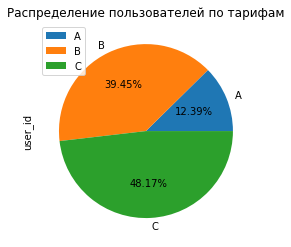

In [81]:
users.groupby(['tariff_plan'])['user_id'].nunique().plot(
    y='user_id',
    kind='pie',
    title='Распределение пользователей по тарифам',
    autopct='%1.2f%%',
    legend=True)
plt.show()

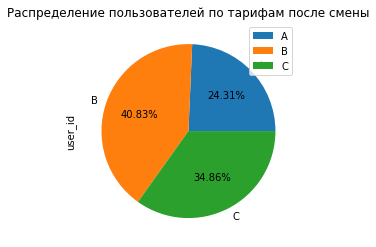

In [82]:
users.groupby(['new_tariff_plan'])['user_id'].nunique().plot(
    y='user_id', 
    kind='pie', 
    title='Распределение пользователей по тарифам после смены',
    autopct='%1.2f%%',
    legend=True)
plt.show()

Изначально на тарифе С находились почти половина пользователей, на втором месте был тариф В, совсем мало пользователей пользовались тарифом А, видимо из за высокой абоненской платы. После смены тарифов количество пользователей на тарифе А сильно выросло, а лидировать стал тариф В.

In [83]:
users.loc[(users['tariff_plan'] == 'A') & (over['new_tariff_plan'] == 'B')]['user_id'].nunique()

7

In [84]:
users.loc[(users['tariff_plan'] == 'B') & (over['new_tariff_plan'] == 'C')]['user_id'].nunique()

16

In [85]:
users.loc[(users['tariff_plan'] == 'A') & (over['new_tariff_plan'] == 'C')]['user_id'].nunique()

2

In [86]:
users.loc[(users['tariff_plan'] == 'B') & (over['new_tariff_plan'] == 'A')]['user_id'].nunique()

24

In [87]:
users.loc[(users['tariff_plan'] == 'C') & (over['new_tariff_plan'] == 'B')]['user_id'].nunique()

38

In [88]:
users.loc[(users['tariff_plan'] == 'C') & (over['new_tariff_plan'] == 'A')]['user_id'].nunique()

27

7 пользователям выгодно перейти с тарифа А на тариф В, 16 с тарифа В на тариф С, 2 с тарифа А на тариф С, 24 с тарифа В на тариф С, 38 с тарифа В на тариф А и 27 с тарифа С на тариф А. Таким образом, 25 пользователю выгодно перейти на тарифы с меньшей абоненской платой, а 89 выгодно перейти на тарифы с большей абоненской платой. Это произошло, потому что многие пользователи находятся на тарифах с небольшой абоненской платой и сильно выходят на рамки тарифа.

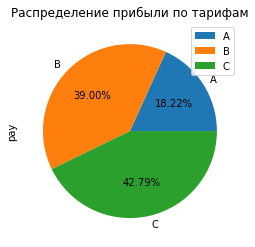

In [89]:
users.groupby(['tariff_plan'])['pay'].sum().plot(
    y='user_id', 
    kind='pie', 
    title='Распределение прибыли по тарифам',
    autopct='%1.2f%%',
    legend=True)
plt.show()

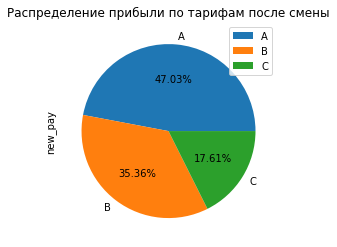

In [90]:
users.groupby(['new_tariff_plan'])['new_pay'].sum().plot(
    y='user_id', 
    kind='pie', 
    title='Распределение прибыли по тарифам после смены',
    autopct='%1.2f%%',
    legend=True)
plt.show()

До смены тарифа больше всего прибыли было от пользователей с тарифом С, совсем мало прибыли от пользователей с тарифом А, это связано с количетсвом пользователей на данных тарифах. После смены тарифа больше всего выгоды выходит от тарифа А, тк много пользователей мы переключили на этот тариф, выгода от тарифа С соотвественно сильно уменьшилась.

До смены тарифов самый прибыльный и самый популярный тариф это тариф С. 89 пользователям выгодно перейти на более дорогой тариф, причем 27 из них выгодно перейти сразу с С на А. Также многим пользователям выгодно перейти с В на С и наоборот, так как у них близка абоненская плата. После смены тарифов по количетству пользователей стал лидировать тариф В, а по прибыли тариф А. Видно, что тариф А выгоден для большого количетсва пользователей, но он не пользуется спросом скорее всего из-за большой абоненской платы.  Проверим статистические гипотезы и сделаем окончательные выводы.

<div class="alert alert-success">
    
**Комментарий ревьюера**

**#ок**

В целом интересные предложения по тарифам. Возможно, я бы не со всеми согласилась, но это возможное видинье.

Однако сами числа искажены пересчетами в секунды. В итоге у тебя слишком решающую роль играет абонентская плата, т.к. оплата самих звонков очень маленькая.

Поэтому давай перерасчитаем и посмотри, что в итоге получится.
</div>



## Проверка статистических гипотез.

### Гипотеза об изменении средней выручки после смены тарифов на более выгодные.

Нулевая гипотеза: после смены тарифа статистических различий в выручке нет. Альтернативная гипотеза: после смены тарифов статистические различия в выручке есть. Выручку будем считать суммарно за три месяца.

In [91]:
sample1 = users.groupby(['user_id']).agg({'pay':'sum'})
sample2 = users.groupby(['user_id']).agg({'new_pay':'sum'})
alpha = 0.05
results = st.mannwhitneyu(sample1, sample2, alternative='two-sided')
print(f'p-значение: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение: [0.69207908]
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [92]:
users.groupby(['user_id']).agg({'new_pay':'sum'}).mean()['new_pay'] - users.groupby(['user_id']).agg({'pay':'sum'}).mean()['pay']

-1219.4938073394515

In [93]:
users.groupby(['user_id']).agg({'new_pay':'sum'}).sum()['new_pay'] - users.groupby(['user_id']).agg({'pay':'sum'}).sum()['pay']

-265849.6500000004

Тест показал, что статистических различий в средней выручке нет. Абсолютная выручка упала на 265850. Можно переводить пользователей на новые тарифы.

### Гипотеза об изменении средней выручки после смены абоненской платы.

In [94]:
def tariff_calc(
    monthly_cost,
    operator_count_monthly_cost,
    prepayed_internal_minutes,
    interanal_minute_cost,
    external_minute_cost,
):
    def _calc(external_minutes, internal_minutes, operator_count):
        return (
            external_minutes * external_minute_cost
            + np.minimum(internal_minutes - prepayed_internal_minutes, 0) * interanal_minute_cost
            + monthly_cost
            + operator_count * operator_count_monthly_cost
        )
    return _calc

tariff_A_calc = tariff_calc(3000, 50, 1500, 0.1, 0.3)
tariff_B_calc = tariff_calc(2000, 150, 500, 0.15, 0.5)
tariff_C_calc = tariff_calc(1000, 300, 0, 0.3, 0.7)

In [95]:
out.loc[out['tariff_plan'] == 'A', 'pay_change_fee'] = out.apply(
    lambda row: tariff_A_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
out.loc[out['tariff_plan'] == 'B', 'pay_change_fee'] = out.apply(
    lambda row: tariff_B_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
out.loc[out['tariff_plan'] == 'C', 'pay_change_fee'] = out.apply(
    lambda row: tariff_C_calc(row['total_call_out_False'], row['total_call_out_True'], row['operator_id']), axis=1)
out['pay'] = out['pay'].fillna(0)
out

,user_id,month,total_call_out_False,total_call_out_True,tariff_plan,operator_id,pay,pay_change_fee
0,166377,9,16233,9.0,B,5,10792.85,10792.85
1,166377,10,13779,5.0,B,5,9565.25,9565.25
2,166377,11,12332,127.0,B,5,8860.05,8860.05
3,166405,9,10800,0.0,B,10,8825.00,8825.00
4,166405,10,26089,778.0,B,10,16544.50,16544.50
...,...,...,...,...,...,...,...,...
453,168481,11,425,0.0,B,3,2587.50,2587.50
454,168500,11,12,30.0,B,1,2085.50,2085.50
455,168601,11,4907,0.0,C,2,5034.90,5034.90
456,168603,11,1187,0.0,B,1,2668.50,2668.50


In [96]:
sample1 = out.groupby(['user_id']).agg({'pay':'sum'})
sample2 = out.groupby(['user_id']).agg({'pay_change_fee':'sum'})
alpha = 0.05
results = st.mannwhitneyu(sample1, sample2, alternative='two-sided')
print(f'p-значение: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение: [0.79723359]
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [97]:
out.groupby(['user_id']).agg({'pay_change_fee':'sum'}).mean()['pay_change_fee'] - out.groupby(['user_id']).agg({'pay':'sum'}).mean()['pay']

-251.37614678899263

In [98]:
out.groupby(['user_id']).agg({'pay_change_fee':'sum'}).sum()['pay_change_fee'] - out.groupby(['user_id']).agg({'pay':'sum'}).sum()['pay']

-54800.000000000466

Если снизить абоненскую плату на тарифе А до 3000, а количество включенных минут на исходящие звонки уменьшить до 1500, то статистических различий в прибыле по результатам теста не обнаружено. Можно попробовать это применить, чтобы больше пользователей выбирали тариф А, не пугаясь большой абоненской платы, таким образом сделать разницу между тарифом А и тарифом В менее явной.

## Выводы.

* В работу взяли пользователей, которые совершали звонки в период с сентрября по ноябрь. Всего мы потеряли около 2 процентов пользователей из анализа. У нас осталось 303 пользователя и 1054 оператора.
* Иключили из анализа аномально продолжительные звонки.
* Обнаружили в столбце пропущенные значений айди операторов, но выяснили, что большая часть приходится на входящие звонки, поэтому было принято решение оставить данные как есть.
* Нашли медиану платы пользователя на каждом тарифе. Медианная плата на тарифе А - 5483.6, на тарифе B - 4117.5, на тарифе С - 3497.1. Медианная плата на тарифе А близка к абонентской плате, так как в тариф включено достаточное количетсво минут, а стоимость остальных услуг низкая. По тарифу В и С медианная плата сильно превышает абонентскую плату по тарифу. 
* Рассмотрим пользователей, которые платят больше, чем по медиане по тарифу. Нашли, что 16 пользователей переплачивают на тарифе А, 46 на тарифе В и 54 на тарифе С хотя бы в одном месяце из двух. 38 пользователей переплачивают одном месяце, 44 в двух, 34 в трех.
* Определим пользователей из переплачивающих, для которых мы можем предложить более выгоднгый тариф. Будем предлагать новый тариф только тем пользователям, для которых мы можем предложить более выгодный тариф хотя бы в двух месяцах из трех. Таких пользователей 141.
* Подсчитали плату каждого пользовалея по месяцам, для переплачивающих пользователей подсчили также плату на новом тарифе.
* Изначально на тарифе С находились почти половина пользователей, на втором месте был тариф В, совсем мало пользователей пользовались тарифом А, видимо из за высокой абоненской платы. После смены тарифов количество пользователей на тарифе А сильно выросло, а лидировать стал тариф В.
* 7 пользователям выгодно перейти с тарифа А на тариф В, 16 с тарифа В на тариф С, 2 с тарифа А на тариф С, 24 с тарифа В на тариф С, 38 с тарифа В на тариф А и 27 с тарифа С на тариф А. Таким образом, 25 пользователю выгодно перейти на тарифы с меньшей абоненской платой, а 89 выгодно перейти на тарифы с большей абоненской платой. Это произошло, потому что многие пользователи находятся на тарифах с небольшой абоненской платой и сильно выходят на рамки тарифа.
* До смены тарифа больше всего прибыли было от пользователей с тарифом С, совсем мало прибыли от пользователей с тарифом А, это связано с количетсвом пользователей на данных тарифах. После смены тарифа больше всего выгоды выходит от тарифа А, тк много пользователей мы переключили на этот тариф, выгода от тарифа С соотвественно сильно уменьшилась.
* Проверили статистическую гипотезу, повлияла ли смена тарифа на среднюю выручку. Тест показал, что не повлияела. 
* Проверили статистическую гипотезу, повлияет ли изменение тарифного плана А на среднюю выручку. Тест показал, что не повлияет.
* Исходя из исследования можно сделать вывод, что можно переводить пользователей на более выгодные тарифы, убытки при этом будут незначительные.
* Стоит обратить внимание на тарифный план А, он не пользуется популярностью из-за высокой абоненской платы, возможно стоит перессмотреть условия тарифа, чтобы сделать его более привлекательным.